In [1]:
import gymnasium as gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [2]:
class Node:
    def __init__(self, state, parent=None, action=None):
        self.state = state  # (state, reward, done)
        self.parent = parent
        self.action = action
        self.children = []
        self.visits = 0
        self.value = 0.0
    
    def is_fully_expanded(self, env):
        possible_actions = range(env.action_space.n)
        return len(self.children) == len(possible_actions)

    def best_child(self, exploration_weight=1.4):
        best_score = -float('inf')
        best_child = None

        for child in self.children:
            score = (child.value / (child.visits + 1e-6)) + exploration_weight * math.sqrt(math.log(self.visits + 1) / (child.visits + 1e-6))
            if score > best_score:
                best_score = score
                best_child = child

        return best_child

    def add_child(self, child_state, action):
        child_node = Node(child_state, self, action)
        self.children.append(child_node)
        return child_node

    def update(self, result):
        self.visits += 1
        self.value += result


In [4]:

class MCTS:
    def __init__(self, env, exploration_weight=1.4):
        self.env = env
        self.exploration_weight = exploration_weight
        self.rewards = []
        self.averages = []
        self.convergence = []
        self.successful = 0

    def search(self, initial_state, num_simulations=1000):
        root = Node(initial_state)

        for i in range(num_simulations):
            node = self._select(root)
            result, count = self._simulate(node)
            avg = result/count
            
            if result == 1:
                self.successful += 1
                self.convergence.append((i, count))
            
            self._backpropagate(node, result)

            self.rewards.append(result)
            self.averages.append(avg)
            self.env.reset()


        return root.best_child(exploration_weight=0).action

    def _select(self, node):
        while not node.state[2]:  # Continue until the state is terminal
            if not node.is_fully_expanded(self.env):
                return self._expand(node)
            else:
                node = node.best_child(self.exploration_weight)
        return node

    def _expand(self, node):
        untried_actions = [action for action in range(self.env.action_space.n)
                            if action not in [child.action for child in node.children]]
        action = random.choice(untried_actions)
        next_state, reward, done, _, _ = self.env.step(action)
        child_node = node.add_child((next_state, reward, done), action)
        return child_node

    def _simulate(self, node):
        total_reward = node.state[1]
        done = node.state[2]
        count = 0
        while not done:
            count += 1
            action = self.env.action_space.sample()
            _, reward, done, _, _ = self.env.step(action)
            total_reward += reward

        return total_reward, count

    def _backpropagate(self, node, result):
        while node is not None:
            node.update(result)
            node = node.parent

In [5]:

# Running MCTS on FrozenLake
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
episodes = [1000, 2500, 5000, 7500, 10000]
tasa_exito = []
initial_state, _ = env.reset()

''' action = ""
while action != "q":
    action = int(input("Elige una accion: "))
    next_state, reward, done, _, _ = env.step(action)
    print(next_state, reward, done) '''


for num_episodes in episodes:
    initial_node_state = (initial_state, 0, False)  # (state, reward, done)
    mcts = MCTS(env)
    best_action = mcts.search(initial_node_state, num_simulations=num_episodes)
    tasa_exito.append((mcts.successful/num_episodes)*100)
    env.reset()

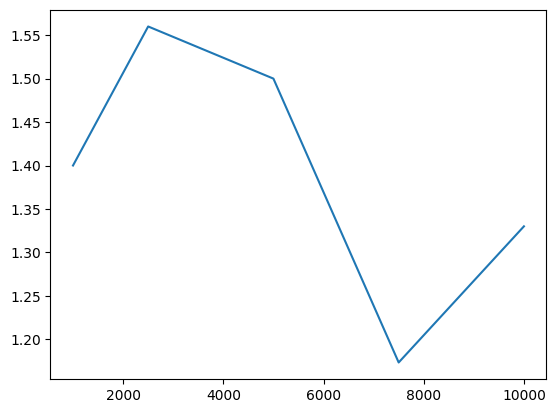

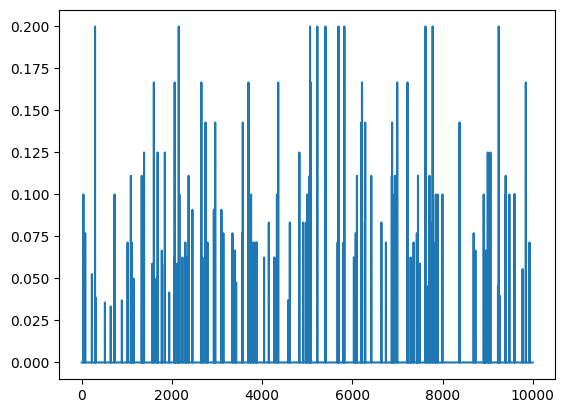

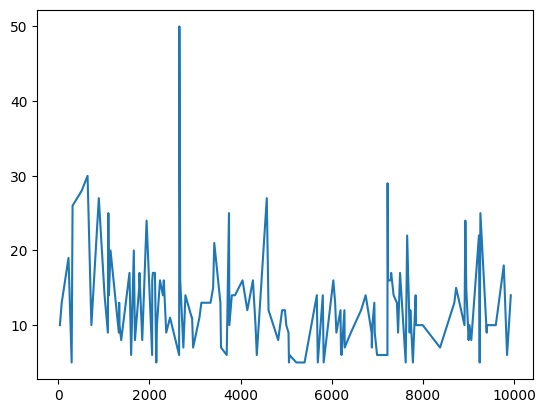

In [6]:


plt.plot(episodes, tasa_exito)
plt.show()
plt.plot(range(10000), mcts.averages)
plt.show()
plt.plot([i[0] for i in mcts.convergence], [j[1] for j in mcts.convergence])
plt.show()


